Preparing the LSTM ,tensorflow imports and necessary imports of packages

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 53960.5938 - val_loss: 5251.8467
Epoch 2/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8241.1641 - val_loss: 2893.1321
Epoch 3/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7459.4507 - val_loss: 2496.2427
Epoch 4/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7341.4141 - val_loss: 2415.6694
Epoch 5/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7497.7173 - val_loss: 2232.1934
Epoch 6/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7091.1069 - val_loss: 2296.8486
Epoch 7/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7053.7539 - val_loss: 2215.9651
Epoch 8/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 7199.8110 - val_loss: 2215.4302
Epoch 9/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7252.2690 - val_loss: 2172.4241
Epoch 10/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6987.5176 - val_loss: 2163.0161
Epoch 11/25
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step -

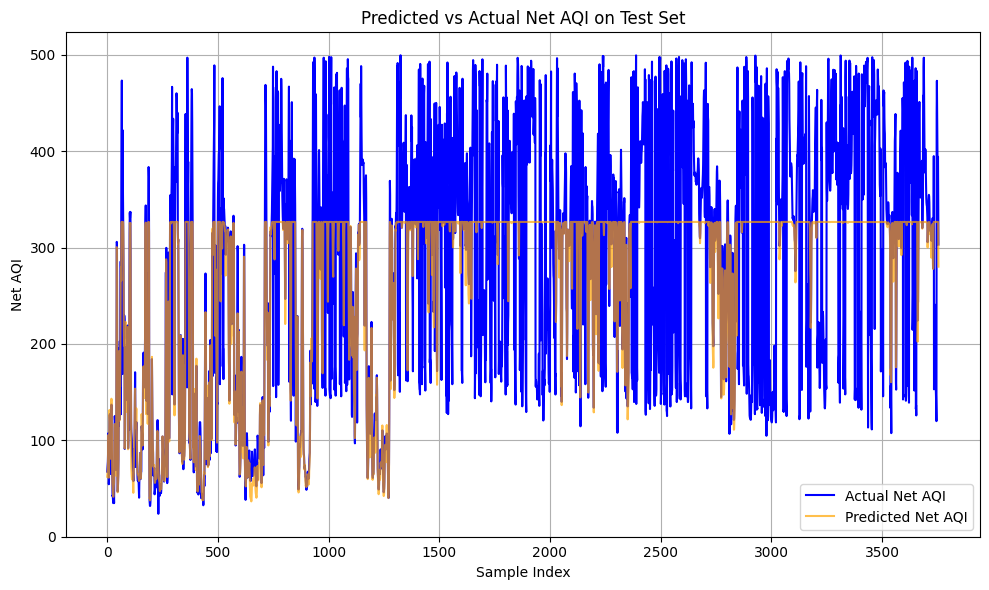

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
class GELU(Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, inputs):
        import tensorflow as tf
        return 0.5 * inputs * (1.0 + tf.tanh(
            np.sqrt(2 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))
        ))

df = pd.read_csv(r"/content/delhi_aqi_minmax_normalized.csv")
df = df.dropna(subset=['Net_AQI'])
feature_cols = [col for col in df.columns if col not in ['date', 'Net_AQI']]
X = df[feature_cols].values


"""normalization of the Target variable so that computation cost is avoided"""
net_aqi_min = df['Net_AQI'].min()
net_aqi_max = df['Net_AQI'].max()
y_norm = (df['Net_AQI'] - net_aqi_min) / (net_aqi_max - net_aqi_min)

# Reshape features for LSTM input -:samples, timesteps=1, features
X = np.expand_dims(X, axis=1)
# Train,test split 80-20
X_train, X_test, y_train_norm, y_test_norm = train_test_split(
    X, y_norm, test_size=0.2, shuffle=False, random_state=42
)

# Building the model layers with a dense layer and 2 LSTM layers to capture long term  time series data and also a dense  layer to allow final mappping of values to the actual values
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(GELU())
model.add(LSTM(64, return_sequences=False))
model.add(GELU())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Final output layer for Net_AQI regression

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Model training using validation split and adjusting epoch and batch size for good final accuracy
history = model.fit(
    X_train, y_train_norm,
    epochs=25,
    batch_size=12,
    validation_split=0.2,
    verbose=1
)


y_pred_norm = model.predict(X_test).flatten()
# Denormalize predictions and true targets for  final evaluation and plotting
y_pred = y_pred_norm * (net_aqi_max - net_aqi_min) + net_aqi_min
y_test = y_test_norm * (net_aqi_max - net_aqi_min) + net_aqi_min
# Evaluation metrics of the model on the test data set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R-2 Score: {r2}')

# Plot predicted vs actual values on a graph for visualization
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Net AQI', color='blue')
plt.plot(y_pred, label='Predicted Net AQI', color='orange', alpha=0.7)
plt.title('Predicted vs Actual Net AQI on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Net AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The model Demonstrated Plateuing for the values of Net AQI  above around 310 due to insufficient capacity and needed normalization of the Net AQI so that computation is reduced and optimal weights are found quicker with less  Relative loss .

AFTer multiple  runs the optimal hyperparameters for the LSTm layers and the Dense layers are found below  and the learning rate is also adjusted so .

Epoch 1/18


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


201/201 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 0.1588 - val_loss: 0.0581
Epoch 2/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0554 - val_loss: 0.0516
Epoch 3/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0521 - val_loss: 0.0502
Epoch 4/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0447 - val_loss: 0.0283
Epoch 5/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0290 - val_loss: 0.0163
Epoch 6/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0182 - val_loss: 0.0102
Epoch 7/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0135 - val_loss: 0.0084
Epoch 8/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0120 - val_loss: 0.0078
Epoch 9/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 10/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 11/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0095 - val_loss: 0.0067
Epoch 12/18
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

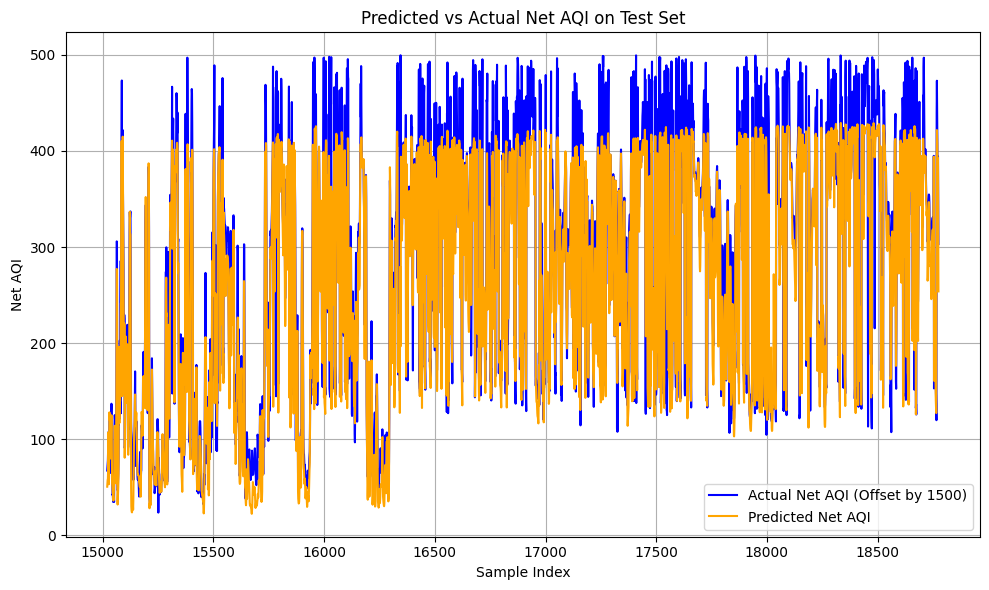

Test RMSE: 41.99899540961219
Test R2 Score: 0.8936937794919488


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
class GELU(Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)
    def call(self, inputs):
        return 0.5 * inputs * (1.0 + tf.tanh(
            np.sqrt(2 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))
        ))
df = pd.read_csv(r"/content/delhi_aqi_minmax_normalized.csv")
df = df.dropna(subset=['Net_AQI'])

feature_cols = [col for col in df.columns if col not in ['date', 'Net_AQI']]
X = df[feature_cols].values
# Normalize target between 0 and 1
min = df['Net_AQI'].min()
max = df['Net_AQI'].max()
#normalizing the final target value so that we have a good convergence
y_norm = (df['Net_AQI'] - min) / (max -min)
X = np.expand_dims(X, axis=1)
indices = np.arange(len(X))

# Train-test split with indices for alignment
X_train, X_test, y_train_norm, y_test_norm, idx_train, idx_test = train_test_split(X, y_norm, indices, test_size=0.2, shuffle=False, random_state=42)

# LSTM Architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(GELU())
model.add(LSTM(64, return_sequences=False))
model.add(GELU())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(
    X_train, y_train_norm,
    epochs=18,
    batch_size=60,
    validation_split=0.2,
    verbose=1
)


y_pred_norm = model.predict(X_test).flatten()
# Denormalize the values of prediction to plot against the actual values
y_pred = y_pred_norm * (net_aqi_max - net_aqi_min) + net_aqi_min
y_test = y_test_norm * (net_aqi_max - net_aqi_min) + net_aqi_min
# Plot with index alignment and offset for actual values
plt.figure(figsize=(10,6))
plt.plot(idx_test , y_test, label='Actual Net AQI (Offset by 1500)', color='blue')
plt.plot(idx_test, y_pred, label='Predicted Net AQI', color='orange')
plt.title('Predicted vs Actual Net AQI on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Net AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate the metrics of the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R2 Score: {r2}')
